<a href="https://colab.research.google.com/github/swapnilmn/Assignment_1-CS6910/blob/master/Question_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Question 3 (24 Marks) Implement the backpropagation algorithm with support for the following optimisation functions
            sgd
            momentum based gradient descent
            nesterov accelerated gradient descent
            rmsprop
            adam
            nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

# Libraries 

In [ ]:
from keras.datasets import fashion_mnist, mnist
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from sklearn.model_selection import train_test_split 
import pandas as pd

In [ ]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=9e06225ff24893a7d84aaceb4f405164459c7e1704d45609caa486b952f829de
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data Processing

In [ ]:
class OneHotEncoder_from_scratch:
    
    def __init__(self):
        self.categories = None
    def fit(self, X):
        self.categories =[]
        for i in range(X.shape[1]):
            feature_categories =list(set(X[:, i]))
            self.categories.append(feature_categories)
            
    def transform(self, X):
        one_hot_vector = []

        for i in range(X.shape[0]):
            one_hot_row = []
            for j in range(X.shape[1]):

                category_index = self.categories[j].index(X[i, j])
                category_one_hot =[0] *len(self.categories[j])
                category_one_hot[category_index] = 1

                one_hot_row.extend(category_one_hot)
            one_hot_vector.append(one_hot_row)
        return np.array(one_hot_vector)

In [ ]:
dataset = 'fashion_mnist'
if dataset == 'fashion_mnist':
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
elif dataset == 'mnist':
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
else:
    raise ValueError('Invalid dataset name')
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
train_input = []
for i in range(len(X_train)):
    train_input.append(list(np.concatenate(X_train[i]).flat))

val_input = []
for i in range(len(X_val)):
    val_input.append(list(np.concatenate(X_val[i]).flat))

test_input = []
for i in range(len(test_images)):
    test_input.append(list(np.concatenate(test_images[i]).flat))
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(test_labels)

X_train = np.array(train_input) / 255.0
X_test = np.array(test_input) / 255.0
X_val = np.array(val_input) / 255.0

enc = OneHotEncoder_from_scratch()
enc.fit(Y_train.reshape(-1, 1))
Y_train = enc.transform(Y_train.reshape(-1, 1))
Y_val = enc.transform(Y_val.reshape(-1, 1))
Y_test = enc.transform(Y_test.reshape(-1, 1))

print(Y_train.shape, Y_val.shape, Y_test.shape)
print(X_train.shape, X_val.shape, X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(54000, 10) (6000, 10) (10000, 10)
(54000, 784) (6000, 784) (10000, 784)


# Class of FeedForward Neural Network

In [ ]:
wandb.init(project = 'Question_4_Best_Model')

class FFNN:
  def __init__(self, X, Y,
               epochs = 100, 
               hidden_layer_count = 4,
               hidden_layers =  [32, 64, 128, 256],
               learning_rate = 0.001,
               batch_size = 32,
               activation='tanh',
               weight_init='random',
               loss = 'MSE',
               weight_decay = 0):
    
    self.inputs =X.shape[1] # Number of inputs
    self.outputs= Y.shape[1] # Number of outputs
    self.epochs = epochs
    self.hidden_layers = hidden_layer_count  # Number of hidden layers 
    self.network_size= [self.inputs] + hidden_layers +[self.outputs] # input layer + hidden layers + output layers
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.weights={} # It will create dictionary for weights and biases
    self.weights_h = []
    self.num_classes = Y.shape[1]
    self.weight_init = weight_init
    self.activation_function = activation
    self.loss_function = loss
    self.lambd = 0
    np.random.seed(0)  # We will set seed value so that it will generate same random numebers every time

    self.grad_derivatice={}
    self.update_weights={}
    self.prev_update_weights={}
    for i in range(1,self.hidden_layers+1):
      vw_key, vb_key, mb_key, mw_key = [f"{key}{i}" for key in ['vw', 'vb', 'mb', 'mw']]
      self.update_weights[vw_key]=0
      self.update_weights[vb_key]=0
      self.update_weights[mb_key]=0
      self.update_weights[mw_key]=0
      self.prev_update_weights[vw_key]=0
      self.prev_update_weights[vb_key]=0

    
    if self.weight_init == 'random':
      for i in range(1, self.hidden_layers + 2):
          weight_shape = (self.network_size[i - 1], self.network_size[i])
          weight_scale = 0.1
          self.weights[f'W{i}'] = np.random.normal(scale=weight_scale, size=weight_shape)*0.1
          
          bias_shape = (1, self.network_size[i])
          self.weights[f'B{i}'] = np.zeros(bias_shape)

    if self.weight_init == 'Xavier':
      for i in range(1, self.hidden_layers + 2):
          weight_shape = (self.network_size[i - 1], self.network_size[i])
          weight_scale = 0.1
          self.weights[f'W{i}'] = np.random.normal(scale=weight_scale, size=weight_shape)*np.sqrt(1/self.network_size[i-1])
          
          bias_shape = (1, self.network_size[i])
          self.weights[f'B{i}'] = np.zeros(bias_shape)

  def forward_activation(self, X):
      activation_functions = {
          'sigmoid': lambda x: 1.0 / (1.0 + np.exp(-x)),
          'tanh': np.tanh,
          'Relu': lambda x: np.maximum(0, x)
      }
      activation_function = activation_functions.get(self.activation_function)
      if activation_function:
          return activation_function(X)
      else:
          raise ValueError(f"Unknown activation function '{self.activation_function}'")


  def grad_activation(self, X):
      activation_gradients = {
          'sigmoid': lambda x: x * (1 - x),
          'tanh': lambda x: 1 - np.square(x),
          'Relu': lambda x: 1.0 * (x > 0)
      }
      gradient_function = activation_gradients.get(self.activation_function)
      if gradient_function:
          return gradient_function(X)
      else:
          raise ValueError(f"Unknown activation function '{self.activation_function}'")


  def softmax(self, X):
    exps =np.exp(X - np.max(X, axis=1, keepdims=True))
    return  exps /np.sum(exps, axis=1, keepdims=True)
  

  def forward_pass(self, X, weights=None):
      if weights is None:
          weights = self.weights
      self.A = {}
      self.H = {}
      self.H[0] = X
      for i in range(self.hidden_layers):
          self.A[i+1] = self.H[i] @ weights[f'W{i+1}'] + weights[f'B{i+1}']
          self.H[i+1] = self.forward_activation(self.A[i+1])
      self.A[self.hidden_layers+1] = self.H[self.hidden_layers] @ weights[f'W{self.hidden_layers+1}'] + weights[f'B{self.hidden_layers+1}']
      self.H[self.hidden_layers+1] = self.softmax(self.A[self.hidden_layers+1])
      return self.H[self.hidden_layers+1]

  def backprop(self, X, Y, weights=None):
    if weights is None:
        weights = self.weights

    self.forward_pass(X, weights)
    self.grad_derivatice = {}
    L = self.hidden_layers + 1

    if self.loss_function == 'CE':
        self.grad_derivatice[f'dA{L}'] = (self.H[L] - Y) * (1/X.shape[0])
    elif self.loss_function == 'MSE':
        self.grad_derivatice[f'dA{L}'] = (1/X.shape[0]) * 2 * (self.H[L] - Y)

    for k in range(L, 0, -1):
        w_key, b_key, dw_key, db_key, da_key = [f"{key}{k}" for key in ['W', 'B', 'dW', 'dB', 'dA']]
        self.grad_derivatice[dw_key] = np.matmul(self.H[k-1].T, self.grad_derivatice[da_key]) + self.lambd * weights[w_key]
        self.grad_derivatice[db_key] = np.sum(self.grad_derivatice[da_key], axis=0).reshape(1, -1)
        self.grad_derivatice[f'dH{k-1}'] = np.matmul(self.grad_derivatice[da_key], weights[w_key].T)
        self.grad_derivatice[f'dA{k-1}'] = np.multiply(self.grad_derivatice[f'dH{k-1}'], self.grad_activation(self.H[k-1]))

    return self.grad_derivatice[f'dH{k-1}']

  def fit(self, X, Y, X_val, Y_val,algo= 'GD',a = 10, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 , show_loss = False):

    if show_loss:
      loss = []
    for num_epoch in tqdm(range(1, self.epochs+1), unit='epoch'):
      m = X.shape[0]
      
      if algo == 'SGD':
        for i in range(m):
            rand_idx = np.random.randint(m)
            x_i = X[rand_idx:rand_idx+1]
            y_i = Y[rand_idx:rand_idx+1]
            self.backprop(x_i, y_i)
            for j in range(1, self.hidden_layers+1):
              w_key, b_key, dw_key, db_key = [f"{key}{j}" for key in ['W', 'B', 'dW', 'dB']]
              self.weights[w_key] -=self.learning_rate * self.grad_derivatice[dw_key]
              self.weights[b_key] -=self.learning_rate * self.grad_derivatice[db_key]
        self.wandlog(num_epoch, X, Y, X_val, Y_val)

      elif algo == 'Momentum':
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size
        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            self.backprop(X_batch, Y_batch)

            for i in range(1, self.hidden_layers+1):
              w_key, b_key, vw_key, vb_key,dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
              self.update_weights[vw_key] = gamma *self.update_weights[vw_key] + self.learning_rate * (self.grad_derivatice[dw_key])
              self.update_weights[vb_key] = gamma *self.update_weights[vb_key] + self.learning_rate * (self.grad_derivatice[db_key])
              self.weights[w_key] -= self.update_weights[vw_key]
              self.weights[b_key] -= self.update_weights[vb_key]
        self.wandlog(num_epoch, X, Y,X_val, Y_val)

      elif algo == 'RMSProp':
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            self.backprop(X_batch, Y_batch)

            for i in range(1, self.hidden_layers+1):
                w_key, b_key, vw_key, vb_key, dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                self.update_weights[vw_key] = beta * self.update_weights[vw_key] + (1 - beta) * ((self.grad_derivatice[dw_key])**2)
                self.update_weights[vb_key] = beta * self.update_weights[vb_key] + (1 - beta) * ((self.grad_derivatice[db_key])**2)
                self.weights[w_key] -= (self.learning_rate / (np.sqrt(self.update_weights[vw_key] + eps))) * (self.grad_derivatice[dw_key])
                self.weights[b_key] -= (self.learning_rate / (np.sqrt(self.update_weights[vb_key] + eps))) * (self.grad_derivatice[db_key])

        self.wandlog(num_epoch, X, Y, X_val, Y_val)
      
      elif algo == 'Adam':

        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            self.backprop(X_batch, Y_batch)

            for i in range(1, self.hidden_layers + 1):
                w_key, b_key, vw_key, vb_key, mw_key, mb_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'mw', 'mb']]
                dw_key, db_key= [f"{key}{i}" for key in ['dW', 'dB']]

                self.update_weights[mw_key] = beta1 * self.update_weights[mw_key] + (1 - beta1) * self.grad_derivatice[dw_key]
                self.update_weights[vw_key] = beta2 * self.update_weights[vw_key] + (1 - beta2) * (self.grad_derivatice[dw_key] ** 2)
                mw_hat = self.update_weights[mw_key] / (1 - np.power(beta1, batch + 1))
                vw_hat = self.update_weights[vw_key] / (1 - np.power(beta2, batch + 1))
                self.weights[w_key] -= (self.learning_rate / np.sqrt(vw_hat + eps)) * mw_hat

                self.update_weights[mb_key] = beta1 * self.update_weights[mb_key] + (1 - beta1) * self.grad_derivatice[db_key]
                self.update_weights[vb_key] = beta2 * self.update_weights[vb_key] + (1 - beta2) * (self.grad_derivatice[db_key] ** 2)
                mb_hat = self.update_weights[mb_key] / (1 - np.power(beta1, batch + 1))
                vb_hat = self.update_weights[vb_key] / (1 - np.power(beta2, batch + 1))
                self.weights[b_key] -= (self.learning_rate / np.sqrt(vb_hat + eps)) * mb_hat

        self.wandlog(num_epoch, X, Y,X_val, Y_val)
          
      elif algo == 'NAG':
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        temp_weights = {}
        for i in range(1, self.hidden_layers+2):
          w_key, b_key = [f"{key}{i}" for key in ['W', 'B']]
          temp_weights[w_key] = np.zeros_like(self.weights[w_key])
          temp_weights[b_key] = np.zeros_like(self.weights[b_key])
        
        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            for i in range(1,self.hidden_layers+1):
                w_key, b_key, vw_key, vb_key,dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                self.update_weights[vw_key]=gamma*self.prev_update_weights[vw_key]
                self.update_weights[vb_key]=gamma*self.prev_update_weights[vb_key]
                temp_weights[w_key]=self.weights[w_key]-self.update_weights[vw_key]
                temp_weights[b_key]=self.weights[b_key]-self.update_weights[vb_key]
            self.backprop(X_batch,Y_batch,temp_weights)
            for i in range(1,self.hidden_layers+1):
                w_key, b_key, vw_key, vb_key,dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                self.update_weights[vw_key] = gamma *self.update_weights[vw_key] + self.learning_rate * (self.grad_derivatice[dw_key])
                self.update_weights[vb_key] = gamma *self.update_weights[vb_key] + self.learning_rate * (self.grad_derivatice[db_key])
                self.weights[w_key] -= self.learning_rate * (self.update_weights[vw_key])
                self.weights[b_key] -= self.learning_rate * (self.update_weights[vb_key]) 

            self.prev_update_weights=self.update_weights

        self.wandlog(num_epoch, X, Y,X_val, Y_val)

      elif algo == 'Nadam':

        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        num_updates = 0
        for i in range(1, self.hidden_layers + 1):
            w_key, b_key, vw_key, vb_key, mw_key, mb_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'mw', 'mb']]
            dw_key, db_key, mw_i_key, mb_i_key = [f"{key}{i}" for key in ['dW', 'dB', 'mw_inf', 'mb_inf']]

            for batch in range(num_batches + 1):
                start_index = batch *self.batch_size
                end_index = min((batch+1)*self.batch_size, num_examples)
                X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

                self.backprop(X_batch, Y_batch)

                num_updates += 1
                self.update_weights.setdefault(mw_i_key, 0)
                self.update_weights[mw_key] = beta1 * self.update_weights[mw_key] + (1 - beta1) * (self.grad_derivatice[dw_key] )
                self.update_weights[vw_key] = beta2 * self.update_weights[vw_key] + (1 - beta2) * ((self.grad_derivatice[dw_key]) ** 2)
                mw_hat = self.update_weights[mw_key] / (1 - np.power(beta1, num_updates))
                vw_hat = self.update_weights[vw_key] / (1 - np.power(beta2, num_updates))
                mw_inf = beta1 * self.update_weights[mw_i_key] + (1 - beta1) * np.abs(self.grad_derivatice[dw_key])
                mw_inf_hat = mw_inf / (1 - np.power(beta1, num_updates))
                self.weights[w_key] -= (self.learning_rate / np.sqrt(vw_hat + eps)) * ((beta1 * mw_hat) + ((1 - beta1) * self.grad_derivatice[dw_key])) / (1 - np.power(beta2, num_updates)) + self.learning_rate * eps * np.sqrt(1 - np.power(beta2, num_updates)) * mw_inf_hat

                self.update_weights.setdefault(mb_i_key, 0)
                self.update_weights[mb_key] = beta1 * self.update_weights[mb_key] + (1 - beta1) * (self.grad_derivatice[db_key])
                self.update_weights[vb_key] = beta2 * self.update_weights[vb_key] + (1 - beta2) * ((self.grad_derivatice[db_key]) ** 2)
                mb_hat = self.update_weights[mb_key] / (1 - np.power(beta1, num_updates))
                vb_hat = self.update_weights[vb_key] / (1 - np.power(beta2, num_updates))
                mb_inf = beta1 * self.update_weights[mb_i_key] + (1 - beta1) * np.abs(self.grad_derivatice[db_key])
                mb_inf_hat = mb_inf / (1 - np.power(beta1, num_updates))
                self.weights[b_key] -= (self.learning_rate / np.sqrt(vb_hat + eps)) * ((beta1 * mb_hat) + ((1 - beta1) * self.grad_derivatice[db_key])) / (1 - np.power(beta2, num_updates)) + self.learning_rate * eps * np.sqrt(1 - np.power(beta2, num_updates)) * mb_inf
        self.wandlog(num_epoch, X, Y,X_val, Y_val)
        
      if show_loss:
        loss.append(self.Loss(X, Y))
    
    if show_loss:
      plt.plot(loss)
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.show()
  
  def predict(self, X):
    Y_pred = (self.forward_pass(X))
    return np.array(Y_pred).squeeze()
  
  def accuracy_score(self, X, Y):
    Y_true = np.argmax(Y, axis=1).reshape(-1, 1)
    pred_labels = np.argmax(self.predict(X), axis=1).reshape(-1,1)
    return np.sum(pred_labels == Y_true) / len(Y)

  def Loss(self, X, Y):
    Y_pred = self.predict(X)
    if self.loss_function== 'CE':
        loss = -np.mean(Y * np.log(Y_pred + 1e-8))
    elif self.loss_function == 'MSE':
        loss = np.mean((Y - Y_pred)**2)
    return loss

  def performance(self, X_test, Y_test):
    loss = self.Loss(X_test, Y_test)
    accuracy = self.accuracy_score(X_test, Y_test)


  def confusion_matrix(self, X, Y):

      actual_labels = np.argmax(Y, axis=1)
      predicted_labels = np.argmax(self.forward_pass(X), axis=1)


      available_classes = np.unique(np.concatenate((actual_labels, predicted_labels)))

      confusion_matrix_ = np.zeros((len(available_classes), len(available_classes)), dtype=int)
      for i, actual in enumerate(available_classes):
          for j, predicted in enumerate(available_classes):
              confusion_matrix_[i,j] = np.where((actual_labels == actual) & (predicted_labels == predicted))[0].shape[0]
      wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
          probs=None,
          y_true=actual_labels,
          preds=predicted_labels,
          class_names=list(available_classes),
          title="Confusion Matrix"
      )})

      return confusion_matrix_



  def confusion_matrix_plot(self, confusion_matrix, title='Confusion matrix', cmap=plt.cm.gray_r):
    confusion_matrix = confusion_matrix/10
    plt.matshow(confusion_matrix, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(confusion_matrix))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('actual')
    plt.xlabel('predicted')


  def wandlog(self, num_epoch, X, Y,X_val, Y_val):
    accuracy = self.accuracy_score(X, Y)
    loss_train = self.Loss(X, Y)
    loss_valid = self.Loss(X_val, Y_val)
    val_accuracy = self.accuracy_score(X_val, Y_val)
    wandb.log({'epoch': num_epoch,           
              'loss': loss_train,
              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy})
    
    if num_epoch % 5== 0:
      accuracy = self.accuracy_score(X, Y)
      loss_train = self.Loss(X, Y)
      loss_valid = self.Loss(X_val, Y_val)
      val_accuracy = self.accuracy_score(X_val, Y_val)
      library = {'epoch': num_epoch,           
              'loss': loss_train,
              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy}

      print('Epoch: {}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(library['epoch'], library['loss'], library['accuracy'], library['val_loss'], library['val_accuracy']))
      if num_epoch == self.epochs:
        print('Model trained successfully !')
  


wandb: Currently logged in as: ed22s009. Use `wandb login --relogin` to force relogin


  0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 5, Train Loss: 0.13555675265563655, Train Accuracy: 0.6874259259259259, Val Loss: 0.13605968411329328, Val Accuracy: 0.6765
Model trained successfully !


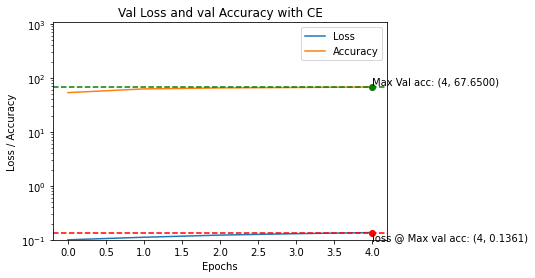

In [ ]:
wandb.init(project = 'Question_4_Best_Model')

class FFNN:
  def __init__(self, X, Y,
               epochs = 100, 
               hidden_layer_count = 4,
               hidden_layers =  [32, 64, 128, 256],
               learning_rate = 0.001,
               batch_size = 32,
               activation='tanh',
               weight_init='random',
               loss = 'MSE',
               weight_decay = 0):
    
    self.inputs =X.shape[1] # Number of inputs
    self.outputs= Y.shape[1] # Number of outputs
    self.epochs = epochs
    self.hidden_layers = hidden_layer_count  # Number of hidden layers 
    self.network_size= [self.inputs] + hidden_layers +[self.outputs] # input layer + hidden layers + output layers
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.weights={} # It will create dictionary for weights and biases
    self.weights_h = []
    self.num_classes = Y.shape[1]
    self.weight_init = weight_init
    self.activation_function = activation
    self.loss_function = loss
    self.lambd = weight_decay
    np.random.seed(0)  # We will set seed value so that it will generate same random numebers every time

    self.grad_derivatice={}
    self.update_weights={}
    self.prev_update_weights={}
    for i in range(1,self.hidden_layers+1):
      vw_key, vb_key, mb_key, mw_key = [f"{key}{i}" for key in ['vw', 'vb', 'mb', 'mw']]
      self.update_weights[vw_key]=0
      self.update_weights[vb_key]=0
      self.update_weights[mb_key]=0
      self.update_weights[mw_key]=0
      self.prev_update_weights[vw_key]=0
      self.prev_update_weights[vb_key]=0

    
    if self.weight_init == 'random':
      for i in range(1, self.hidden_layers + 2):
          weight_shape = (self.network_size[i - 1], self.network_size[i])
          weight_scale = 0.1
          self.weights[f'W{i}'] = np.random.normal(scale=weight_scale, size=weight_shape)*0.1
          
          bias_shape = (1, self.network_size[i])
          self.weights[f'B{i}'] = np.zeros(bias_shape)

    if self.weight_init == 'Xavier':
      for i in range(1, self.hidden_layers + 2):
          weight_shape = (self.network_size[i - 1], self.network_size[i])
          weight_scale = 0.1
          self.weights[f'W{i}'] = np.random.normal(scale=weight_scale, size=weight_shape)*np.sqrt(1/self.network_size[i-1])
          
          bias_shape = (1, self.network_size[i])
          self.weights[f'B{i}'] = np.zeros(bias_shape)

  def forward_activation(self, X):
      activation_functions = {
          'sigmoid': lambda x: 1.0 / (1.0 + np.exp(-x)),
          'tanh': np.tanh,
          'Relu': lambda x: np.maximum(0, x)
      }
      activation_function = activation_functions.get(self.activation_function)
      if activation_function:
          return activation_function(X)
      else:
          raise ValueError(f"Unknown activation function '{self.activation_function}'")


  def grad_activation(self, X):
      activation_gradients = {
          'sigmoid': lambda x: x * (1 - x),
          'tanh': lambda x: 1 - np.square(x),
          'Relu': lambda x: 1.0 * (x > 0)
      }
      gradient_function = activation_gradients.get(self.activation_function)
      if gradient_function:
          return gradient_function(X)
      else:
          raise ValueError(f"Unknown activation function '{self.activation_function}'")


  def softmax(self, X):
    exps =np.exp(X - np.max(X, axis=1, keepdims=True))
    return  exps /np.sum(exps, axis=1, keepdims=True)
  

  def forward_pass(self, X, weights=None):
      if weights is None:
          weights = self.weights
      self.A = {}
      self.H = {}
      self.H[0] = X
      for i in range(self.hidden_layers):
          self.A[i+1] = self.H[i] @ weights[f'W{i+1}'] + weights[f'B{i+1}']
          self.H[i+1] = self.forward_activation(self.A[i+1])
      self.A[self.hidden_layers+1] = self.H[self.hidden_layers] @ weights[f'W{self.hidden_layers+1}'] + weights[f'B{self.hidden_layers+1}']
      self.H[self.hidden_layers+1] = self.softmax(self.A[self.hidden_layers+1])
      return self.H[self.hidden_layers+1]

  def backprop(self, X, Y, weights=None):
    if weights is None:
        weights = self.weights

    self.forward_pass(X, weights)
    self.grad_derivatice = {}
    L = self.hidden_layers + 1

    if self.loss_function == 'CE':
        self.grad_derivatice[f'dA{L}'] =  (self.H[L] - Y)
    elif self.loss_function == 'MSE':
        self.grad_derivatice[f'dA{L}'] = (1/X.shape[0]) * 2 * (self.H[L] - Y)

    for k in range(L, 0, -1):
        w_key, b_key, dw_key, db_key, da_key = [f"{key}{k}" for key in ['W', 'B', 'dW', 'dB', 'dA']]
        self.grad_derivatice[dw_key] = np.matmul(self.H[k-1].T, self.grad_derivatice[da_key]) + self.lambd * weights[w_key]
        self.grad_derivatice[db_key] = np.sum(self.grad_derivatice[da_key], axis=0).reshape(1, -1) + + self.lambd * weights[b_key]
        self.grad_derivatice[f'dH{k-1}'] = np.matmul(self.grad_derivatice[da_key], weights[w_key].T)
        self.grad_derivatice[f'dA{k-1}'] = np.multiply(self.grad_derivatice[f'dH{k-1}'], self.grad_activation(self.H[k-1]))

    return self.grad_derivatice[f'dH{k-1}']

  def fit(self, X, Y, X_val, Y_val,algo= 'GD',a = 10, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9, show_loss = False):
    if show_loss:
      los = []
      accuracy = []
    for num_epoch in tqdm(range(1, self.epochs+1), unit='epoch'):
      m = X.shape[0]
      
      if algo == 'SGD':
        for i in range(m):
            rand_idx = np.random.randint(m)
            x_i = X[rand_idx:rand_idx+1]
            y_i = Y[rand_idx:rand_idx+1]
            self.backprop(x_i, y_i)
            for j in range(1, self.hidden_layers+1):
              w_key, b_key, dw_key, db_key = [f"{key}{j}" for key in ['W', 'B', 'dW', 'dB']]
              self.weights[w_key] -=self.learning_rate * self.grad_derivatice[dw_key]
              self.weights[b_key] -=self.learning_rate * self.grad_derivatice[db_key]
        self.wandlog(num_epoch, X, Y, X_val, Y_val)

      elif algo == 'Momentum':
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size
        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            self.backprop(X_batch, Y_batch)

            for i in range(1, self.hidden_layers+1):
              w_key, b_key, vw_key, vb_key,dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
              self.update_weights[vw_key] = gamma *self.update_weights[vw_key] + self.learning_rate * (self.grad_derivatice[dw_key])
              self.update_weights[vb_key] = gamma *self.update_weights[vb_key] + self.learning_rate * (self.grad_derivatice[db_key])
              self.weights[w_key] -= self.update_weights[vw_key]
              self.weights[b_key] -= self.update_weights[vb_key]
        self.wandlog(num_epoch, X, Y,X_val, Y_val)

      elif algo == 'RMSProp':
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            self.backprop(X_batch, Y_batch)

            for i in range(1, self.hidden_layers+1):
                w_key, b_key, vw_key, vb_key, dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                self.update_weights[vw_key] = beta * self.update_weights[vw_key] + (1 - beta) * ((self.grad_derivatice[dw_key])**2)
                self.update_weights[vb_key] = beta * self.update_weights[vb_key] + (1 - beta) * ((self.grad_derivatice[db_key])**2)
                self.weights[w_key] -= (self.learning_rate / (np.sqrt(self.update_weights[vw_key] + eps))) * (self.grad_derivatice[dw_key])
                self.weights[b_key] -= (self.learning_rate / (np.sqrt(self.update_weights[vb_key] + eps))) * (self.grad_derivatice[db_key])

        self.wandlog(num_epoch, X, Y, X_val, Y_val)
      
      elif algo == 'Adam':

        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            self.backprop(X_batch, Y_batch)

            for i in range(1, self.hidden_layers + 1):
                w_key, b_key, vw_key, vb_key, mw_key, mb_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'mw', 'mb']]
                dw_key, db_key= [f"{key}{i}" for key in ['dW', 'dB']]

                self.update_weights[mw_key] = beta1 * self.update_weights[mw_key] + (1 - beta1) * self.grad_derivatice[dw_key]
                self.update_weights[vw_key] = beta2 * self.update_weights[vw_key] + (1 - beta2) * (self.grad_derivatice[dw_key] ** 2)
                mw_hat = self.update_weights[mw_key] / (1 - np.power(beta1, batch + 1))
                vw_hat = self.update_weights[vw_key] / (1 - np.power(beta2, batch + 1))
                self.weights[w_key] -= (self.learning_rate / np.sqrt(vw_hat + eps)) * mw_hat

                self.update_weights[mb_key] = beta1 * self.update_weights[mb_key] + (1 - beta1) * self.grad_derivatice[db_key]
                self.update_weights[vb_key] = beta2 * self.update_weights[vb_key] + (1 - beta2) * (self.grad_derivatice[db_key] ** 2)
                mb_hat = self.update_weights[mb_key] / (1 - np.power(beta1, batch + 1))
                vb_hat = self.update_weights[vb_key] / (1 - np.power(beta2, batch + 1))
                self.weights[b_key] -= (self.learning_rate / np.sqrt(vb_hat + eps)) * mb_hat

        self.wandlog(num_epoch, X, Y,X_val, Y_val)
          
      elif algo == 'NAG':
        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        temp_weights = {}
        for i in range(1, self.hidden_layers+2):
          w_key, b_key = [f"{key}{i}" for key in ['W', 'B']]
          temp_weights[w_key] = np.zeros_like(self.weights[w_key])
          temp_weights[b_key] = np.zeros_like(self.weights[b_key])
        
        for batch in range(num_batches + 1):
            start_index = batch *self.batch_size
            end_index = min((batch+1)*self.batch_size, num_examples)
            X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

            for i in range(1,self.hidden_layers+1):
                w_key, b_key, vw_key, vb_key,dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                self.update_weights[vw_key]=gamma*self.prev_update_weights[vw_key]
                self.update_weights[vb_key]=gamma*self.prev_update_weights[vb_key]
                temp_weights[w_key]=self.weights[w_key]-self.update_weights[vw_key]
                temp_weights[b_key]=self.weights[b_key]-self.update_weights[vb_key]
            self.backprop(X_batch,Y_batch,temp_weights)
            for i in range(1,self.hidden_layers+1):
                w_key, b_key, vw_key, vb_key,dw_key, db_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'dW', 'dB']]
                self.update_weights[vw_key] = gamma *self.update_weights[vw_key] + self.learning_rate * (self.grad_derivatice[dw_key])
                self.update_weights[vb_key] = gamma *self.update_weights[vb_key] + self.learning_rate * (self.grad_derivatice[db_key])
                self.weights[w_key] -= self.learning_rate * (self.update_weights[vw_key]/m)
                self.weights[b_key] -= self.learning_rate * (self.update_weights[vb_key]/m) 

            self.prev_update_weights=self.update_weights

        self.wandlog(num_epoch, X, Y,X_val, Y_val)

      elif algo == 'Nadam':

        num_examples = X.shape[0]
        num_batches = num_examples //self.batch_size

        num_updates = 0
        for i in range(1, self.hidden_layers + 1):
            w_key, b_key, vw_key, vb_key, mw_key, mb_key = [f"{key}{i}" for key in ['W', 'B', 'vw', 'vb', 'mw', 'mb']]
            dw_key, db_key, mw_i_key, mb_i_key = [f"{key}{i}" for key in ['dW', 'dB', 'mw_inf', 'mb_inf']]

            for batch in range(num_batches + 1):
                start_index = batch *self.batch_size
                end_index = min((batch+1)*self.batch_size, num_examples)
                X_batch, Y_batch = X[start_index:end_index], Y[start_index:end_index]

                self.backprop(X_batch, Y_batch)

                num_updates += 1
                self.update_weights.setdefault(mw_i_key, 0)
                self.update_weights[mw_key] = beta1 * self.update_weights[mw_key] + (1 - beta1) * (self.grad_derivatice[dw_key] )
                self.update_weights[vw_key] = beta2 * self.update_weights[vw_key] + (1 - beta2) * ((self.grad_derivatice[dw_key]) ** 2)
                mw_hat = self.update_weights[mw_key] / (1 - np.power(beta1, num_updates))
                vw_hat = self.update_weights[vw_key] / (1 - np.power(beta2, num_updates))
                mw_inf = beta1 * self.update_weights[mw_i_key] + (1 - beta1) * np.abs(self.grad_derivatice[dw_key])
                mw_inf_hat = mw_inf / (1 - np.power(beta1, num_updates))
                self.weights[w_key] -= (self.learning_rate / np.sqrt(vw_hat + eps)) * ((beta1 * mw_hat) + ((1 - beta1) * self.grad_derivatice[dw_key])) / (1 - np.power(beta2, num_updates)) + self.learning_rate * eps * np.sqrt(1 - np.power(beta2, num_updates)) * mw_inf_hat

                self.update_weights.setdefault(mb_i_key, 0)
                self.update_weights[mb_key] = beta1 * self.update_weights[mb_key] + (1 - beta1) * (self.grad_derivatice[db_key])
                self.update_weights[vb_key] = beta2 * self.update_weights[vb_key] + (1 - beta2) * ((self.grad_derivatice[db_key]) ** 2)
                mb_hat = self.update_weights[mb_key] / (1 - np.power(beta1, num_updates))
                vb_hat = self.update_weights[vb_key] / (1 - np.power(beta2, num_updates))
                mb_inf = beta1 * self.update_weights[mb_i_key] + (1 - beta1) * np.abs(self.grad_derivatice[db_key])
                mb_inf_hat = mb_inf / (1 - np.power(beta1, num_updates))
                self.weights[b_key] -= (self.learning_rate / np.sqrt(vb_hat + eps)) * ((beta1 * mb_hat) + ((1 - beta1) * self.grad_derivatice[db_key])) / (1 - np.power(beta2, num_updates)) + self.learning_rate * eps * np.sqrt(1 - np.power(beta2, num_updates)) * mb_inf
        self.wandlog(num_epoch, X, Y,X_val, Y_val)
      
      if show_loss:
        loss, acc = self.performance(X_val, Y_val)
        acc = acc * 100
        los.append(loss)
        accuracy.append(acc)



    if show_loss:

          max_acc_index = np.argmax(accuracy)

          plt.plot(los, label='Loss')
          plt.plot(accuracy, label='Accuracy')
          plt.plot(max_acc_index, los[max_acc_index], marker='o', color='red')
          plt.plot(max_acc_index, accuracy[max_acc_index], marker='o', color='green')

          plt.text(max_acc_index, los[max_acc_index], f"loss @ Max val acc: ({max_acc_index}, {los[max_acc_index]:.4f})", ha='left', va='top')
          plt.text(max_acc_index, accuracy[max_acc_index], f"Max Val acc: ({max_acc_index}, {accuracy[max_acc_index]:.4f})", ha='left', va='bottom')


          plt.axhline(los[max_acc_index], color='red', linestyle='--')
          plt.axhline(accuracy[max_acc_index], color='green', linestyle='--')
          plt.yscale('log')


          plt.ylim([min(los + accuracy) , max(los + accuracy) + 1000])  

          plt.title('Val Loss and val Accuracy with {}'.format(self.loss_function))
          plt.xlabel('Epochs')
          plt.ylabel('Loss / Accuracy')
          plt.legend()
          plt.show()


  def predict(self, X):
    Y_pred = (self.forward_pass(X))
    return np.array(Y_pred).squeeze()
  
  def accuracy_score(self, X, Y):
    Y_true = np.argmax(Y, axis=1).reshape(-1, 1)
    pred_labels = np.argmax(self.predict(X), axis=1).reshape(-1,1)
    return np.sum(pred_labels == Y_true) / len(Y)

  def Loss(self, X, Y):
      Y_pred = self.predict(X)
      if self.loss_function == 'CE':
          loss = -np.mean(Y * np.log(Y_pred + 1e-8))
          max_loss = -np.mean(Y * np.log(1e-8))
      elif self.loss_function == 'MSE':
          loss = np.mean((Y - Y_pred)**2)
          max_loss = np.mean(Y**2)
      reg_loss = 0
      for layer in range(1, self.hidden_layers + 2):
          w_key = f"W{layer}"
          reg_loss += np.sum(np.square(self.weights[w_key]))
      reg_loss = 0.5 * self.lambd * reg_loss
      loss += reg_loss
      max_reg_loss = 0.5 * self.lambd * np.sum(np.square(self.weights[w_key]))
      max_loss += max_reg_loss
      loss = loss / max_loss
      return loss


  def performance(self, X_test, Y_test):
    loss = self.Loss(X_test, Y_test)
    accuracy = self.accuracy_score(X_test, Y_test)
    return loss, accuracy


  def confusion_matrix(self, X, Y):

      actual_labels = np.argmax(Y, axis=1)
      predicted_labels = np.argmax(self.forward_pass(X), axis=1)


      available_classes = np.unique(np.concatenate((actual_labels, predicted_labels)))

      confusion_matrix_ = np.zeros((len(available_classes), len(available_classes)), dtype=int)
      for i, actual in enumerate(available_classes):
          for j, predicted in enumerate(available_classes):
              confusion_matrix_[i,j] = np.where((actual_labels == actual) & (predicted_labels == predicted))[0].shape[0]
      wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
          probs=None,
          y_true=actual_labels,
          preds=predicted_labels,
          class_names=list(available_classes),
          title="Confusion Matrix"
      )})

      return confusion_matrix_



  def confusion_matrix_plot(self, confusion_matrix, title='Confusion matrix', cmap=plt.cm.gray_r):
    confusion_matrix = confusion_matrix/10
    plt.matshow(confusion_matrix, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(confusion_matrix))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('actual')
    plt.xlabel('predicted')


  def wandlog(self, num_epoch, X, Y,X_val, Y_val):
    accuracy = self.accuracy_score(X, Y)
    loss_train = self.Loss(X, Y)
    loss_valid = self.Loss(X_val, Y_val)
    val_accuracy = self.accuracy_score(X_val, Y_val)
    wandb.log({'epoch': num_epoch,           
              'loss': loss_train,
              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy})
    
    if num_epoch % 5== 0:
      accuracy = self.accuracy_score(X, Y)
      loss_train = self.Loss(X, Y)
      loss_valid = self.Loss(X_val, Y_val)
      val_accuracy = self.accuracy_score(X_val, Y_val)
      library = {'epoch': num_epoch,           
              'loss': loss_train,
              'accuracy': accuracy,
              'val_loss': loss_valid,
              'val_accuracy': val_accuracy}

      print('Epoch: {}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(library['epoch'], library['loss'], library['accuracy'], library['val_loss'], library['val_accuracy']))
      if num_epoch == self.epochs:
        print('Model trained successfully !')

model = FFNN(X_train, Y_train,
                  epochs = 5, 
                  hidden_layer_count = 3,
                  hidden_layers =  [64, 64, 64],
                  learning_rate = 0.0001,
                  batch_size = 32,
                  activation='Relu',
                  weight_init='random',
                  loss = 'CE',
                  weight_decay = 0.0005)
model.fit(X_train, Y_train, X_val, Y_val,algo= 'Adam', a = 1, show_loss = True)